## LOAD DATA

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch
import torchvision 
from torchvision import transforms
from copy import deepcopy
import torch.nn.functional as F
import time
import scipy.ndimage as nd
import imageio
import os
import requests
import zipfile
from tqdm import tqdm  # Để hiển thị tiến trình tải
def load_mnist(batch_size,norm_factor=1):
    transform = transforms.Compose([transforms.ToTensor()])
    trainset = torchvision.datasets.MNIST(root='./mnist_data', train=True,
                                            download=True, transform=transform)
    print("trainset: ", trainset)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True)
    print("trainloader: ", trainloader)
    trainset = list(iter(trainloader))

    testset = torchvision.datasets.MNIST(root='./mnist_data', train=False,
                                        download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=True)
    testset = list(iter(testloader))
    #for i,(img, label) in enumerate(trainset):
    #    trainset[i] = (img.reshape(len(img),784) /norm_factor ,label)
    #for i,(img, label) in enumerate(testset):
    #    testset[i] = (img.reshape(len(img),784) /norm_factor ,label)
    return trainset, testset

def get_cifar10(batch_size):
    transform = transforms.Compose([transforms.ToTensor()])#, transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
    trainset = torchvision.datasets.CIFAR10(root='./cifar_data', train=True,
                                            download=True,transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                      shuffle=True)
    train_data = list(iter(trainloader))
    testset = torchvision.datasets.CIFAR10(root='./cifar_data', train=False,
                                            download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                      shuffle=True)
    test_data = list(iter(testloader))
    return train_data, test_data

def get_id_dictionary(path):
    id_dict = {}
    for i, line in enumerate(open( path + 'wnids.txt', 'r')):
        id_dict[line.replace('\n', '')] = i
    return id_dict
  
def get_class_to_id_dict(path):
    id_dict = get_id_dictionary()
    all_classes = {}
    result = {}
    for i, line in enumerate(open( path + 'words.txt', 'r')):
        n_id, word = line.split('\t')[:2]
        all_classes[n_id] = word
    for key, value in id_dict.items():
        result[value] = (key, all_classes[key])      
    return result

def get_data(path,id_dict):
    print('starting loading data')
    train_data, test_data = [], []
    train_labels, test_labels = [], []
    t = time.time()
    for key, value in id_dict.items():
        train_data += [plt.imread( path + 'train/{}/images/{}_{}.JPEG'.format(key, key, str(i)), format='RGB') for i in range(500)]
        train_labels_ = np.array([[0]*200]*500)
        train_labels_[:, value] = 1
        train_labels += train_labels_.tolist()

    for line in open( path + 'val/val_annotations.txt'):
        img_name, class_id = line.split('\t')[:2]
        test_data.append(plt.imread( path + 'val/images/{}'.format(img_name) ,format='RGB'))
        test_labels_ = np.array([[0]*200])
        test_labels_[0, id_dict[class_id]] = 1
        test_labels += test_labels_.tolist()

    print('finished loading data, in {} seconds'.format(time.time() - t))
    return train_data, train_labels, test_data, test_labels

def parse_train_data(train_images, train_labels,N_imgs):
    images = torch.zeros((N_imgs, 64,64,3))
    for i,(img,label) in enumerate(zip(train_images, train_labels)):
        if i >= N_imgs:
            break
        print(i)
        if len(img.shape) == 3:
            images[i,:,:,:] = torch.tensor(img,dtype=torch.float) / 255.0 # normalize
            #labels.append(torch.tensor(label, dtype=torch.float))
    return torch.tensor(images)


def download_file(url, filename):
   """Tải file từ URL với thanh tiến trình"""
   response = requests.get(url, stream=True)
   total_size = int(response.headers.get('content-length', 0))
   block_size = 1024
   progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True)
   
   with open(filename, 'wb') as f:
       for data in response.iter_content(block_size):
           progress_bar.update(len(data))
           f.write(data)
   progress_bar.close()
    


## MAIN FUNCTION

In [3]:
import numpy as np 
from copy import deepcopy
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F



# Tác dụng: Thêm nhiễu Gaussian vào hình ảnh để làm méo. Mức độ nhiễu được điều khiển bởi sigma.
# Đầu ra: Hình ảnh bị nhiễu, với các giá trị pixel được kẹp lại trong khoảng [0, 1].
def gaussian_perturb_image(img, sigma=0.1):
	#print(img.shape)
	if len(img.shape) != 1:
		total_img_len = np.prod(np.array(img.shape))
		img = img.reshape(total_img_len)
	N = len(img)
	variance = torch.tensor(np.identity(N) * sigma).float()
	perturb = torch.normal(0,sigma,size=[N,])
	return torch.clamp(torch.abs(img + perturb),0,1)


#_____________________________Hàm đo độ tương đồng hoặc khoảng cách_________________________________________________________

# Tác dụng: Tính điểm tương đồng giữa X và z bằng tích vô hướng (dot product).
# Đầu ra: Giá trị điểm tương đồng.
def dot_product_distance(X,z):
	return X @ z.reshape(len(z[0,:]))

# Tác dụng: Tính điểm tương đồng bằng tích vô hướng chuẩn hóa, nhằm đảm bảo các giá trị nằm trong khoảng [0, 1].
# Đầu ra: Giá trị điểm tương đồng chuẩn hóa.
def normalized_dot_product(X,z):
	norm_X = X / torch.sum(X, axis=1).reshape(X.shape[0],1)
	norm_z = z / torch.sum(z)
	dots = norm_X @ norm_z.reshape(len(z[0,:]))
	recip = dots
	norm_dot = recip / torch.sum(recip)
	return norm_dot

# Tác dụng: Tính độ tương đồng cosin giữa hai vector, dựa trên góc giữa chúng.
# Đầu ra: Giá trị độ tương đồng cosin.
def cosine_similarity(X,z):
	return (X @ z.reshape(len(z[0,:]))) / (torch.norm(X) * torch.norm(z))

# Tác dụng: Tính khoảng cách Manhattan (tổng độ chênh lệch tuyệt đối) giữa X và z.
# Đầu ra: Giá trị khoảng cách.
def manhatten_distance(X,z):
	return 1/torch.sum(torch.abs(z - X),axis=1)
	#return -torch.sum(torch.abs(z - X), axis=1)

# Tác dụng: Tính khoảng cách Euclid (tổng bình phương độ chênh lệch) giữa X và z.
# Đầu ra: Giá trị khoảng cách.
def euclidean_distance(X,z):
	return 1/torch.sum(torch.square(z - X),axis=1)
	#return -torch.sum(torch.square(z - X),axis=1)

#_____________________________Hàm chung cho quy tắc cập nhật_________________________________________________________
# Tác dụng: Cập nhật vector z dựa trên hàm độ tương đồng sim và hàm tách sep. Tùy chọn chuẩn hóa kết quả nếu norm là True.
# Đầu ra: Vector z được cập nhật.
def general_update_rule(X,z,beta,sim, sep=F.softmax,sep_param=1000000,norm=True):
	sim_score = sim(X,z)
	#print("SIMS: ", sim_score)
	if norm:
		sim_score = sim_score / torch.sum(sim_score)
	sep_score = F.softmax(sep_param*sim_score,dim=0)  #sep
	if norm:
		sep_score = sep_score / torch.sum(sep_score)
	#print("AUTO SEP SCORE: ", sep_score)
	out = X.T @ sep_score
	return out


### potential separation functions --  linear, sublinear (sqrt, log), polynomial, exponential, max ###
#_____________________________Hàm tách giá trị_________________________________________________________

def separation_log(x, param):
	return torch.log(x)

def separation_identity(x,param):
	return x

def separation_softmax(x,param):
	return F.softmax(param * x) # param = beta = softmax temperature

def separation_polynomial(x,param):	
    return torch.pow(x, param)

def separation_square(x,param):
	return separation_polynomial(x,2)

def separation_cube(x,param):
	return separation_polynomial(x,3)

def separation_sqrt(x,param):
	return separation_polynomial(x,0.5)

def separation_quartic(x,param):
	return separation_polynomial(x,4)

def separation_ten(x,param):
	return separation_polynomial(x,10)

def separation_max(x, param):
	z = torch.zeros(len(x))
	idx = torch.argmax(x).item()
	z[idx] = 1
	return z # create one hot vector based around the max

# function to iterate through the images, retrieve the output and compute the amount of correctly retrieved image queries
# Mục đích: Hàm reshape_img_list được sử dụng để chuyển đổi một danh sách các hình ảnh thành một ma trận, trong đó mỗi hàng là một hình ảnh 
# được làm phẳng (flattened) thành một vector. Nó cũng có thể áp dụng một hàm tùy chọn để biến đổi các hình ảnh trước khi thêm chúng vào ma trận.
# Đầu ra: Ma trận chứa tất cả các hình ảnh được làm phẳng thành vector. Kích thước của ma trận này sẽ là (số lượng hình ảnh, imglen). 
# Mỗi hàng trong ma trận là một hình ảnh đã được làm phẳng.
def reshape_img_list(imglist, imglen, opt_fn = None):
	new_imglist = torch.zeros(len(imglist), imglen)
	for i,img in enumerate(imglist):
		img = img.reshape(imglen)
		if opt_fn is not None:
			img = opt_fn(img)
		new_imglist[i,:] = img
	return new_imglist


#_____________________________Hàm chính để kiểm tra khả năng nhớ________________________________________________________

# key functions which actually tests the storage capacity of the associative memory
# Tác dụng: Kiểm tra khả năng của mạng trí nhớ liên kết trong việc lưu trữ và khôi phục hình ảnh sau khi chúng bị biến dạng. 
# hàm này so sánh hình ảnh gốc với hình ảnh đã được khôi phục và tính tỷ lệ chính xác.
# Đầu ra: Tỷ lệ chính xác khi khôi phục hình ảnh.
def PC_retrieve_store_continuous(imgs,N, P = None, beta=1,num_plot = 5,similarity_metric="error",f=manhatten_distance, image_perturb_fn = gaussian_perturb_image,sigma=0.5,sep_fn=separation_softmax, sep_param=1000000, use_norm = True,ERROR_THRESHOLD = 60, network_type="", return_sqdiff_outputs = False, plot_example_reconstructions = False):
	X = imgs[0:N,:]
	img_len = np.prod(np.array(X[0].shape))
	if len(X.shape) != 2:
		X = reshape_img_list(X, img_len)
	N_correct = 0
	#ERROR_THRESHOLD = 80
	for j in range(N):
		z = image_perturb_fn(X[j,:],sigma).reshape(1,img_len)
		if P is None: # autoassociative
			out = general_update_rule(X,z,beta, f,sep=sep_fn, sep_param=sep_param,norm=use_norm).reshape(img_len)
			sqdiff = torch.sum(torch.square(X[j,:] - out))
			if plot_example_reconstructions:
				plt.imshow(X[j,:].reshape(3,32,32).permute(1,2,0))
				plt.show()
				plt.imshow(z.reshape(3,32,32).permute(1,2,0))
				plt.show()
				plt.imshow(out.reshape(3,32,32).permute(1,2,0))
				plt.show()
				print("SQDIFF: ", sqdiff)
		
		if torch.abs(sqdiff) <= ERROR_THRESHOLD:
			N_correct +=1
		if j < num_plot:
			fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
			titles = ["Original","Masked","Reconstruction"]
			plot_list = [X[j,:], z, out]
			for i, ax in enumerate(axs.flatten()):
				plt.sca(ax)
				#print(imgs[0].shape)
				if len(imgs[0].shape) == 3:
					plt.imshow(plot_list[i].reshape(imgs[0].shape).permute(1,2,0))
				else:
					plt.imshow(plot_list[i].reshape(28,28))
				plt.title(titles[i])
			plt.show()
	return N_correct / N




## PLOTTING

In [4]:
# functions for plotting graphs given the associative memory networks
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
from copy import deepcopy
import pickle

SAVE_FORMAT = "png"

# Hàm: parse_sname_for_title
# Đầu vào: sname (chuỗi tên tập dữ liệu)
# Tác dụng: Xác định tiêu đề dựa trên tên tập dữ liệu.
# Đầu ra: Tiêu đề chuỗi (MNIST, CIFAR10, hoặc ImageNet)
def parse_sname_for_title(sname):
    if "tiny_" in sname or "imagenet_" in sname:
        return "ImageNet"
    if "mnist_" in sname:
        return "MNIST"
    else:
        return "CIFAR10"

# Hàm: plot_capacity_graphs
# Đầu vào: Ns (danh sách số lượng hình ảnh), imgs (dữ liệu ảnh), beta (tham số cập nhật), fs (các hàm đo độ tương đồng), labels (nhãn)
#          image_perturb_fn (hàm biến đổi ảnh), sep_fn (hàm tách), sep_param (tham số tách), sigma (độ lệch chuẩn), plot_results (có vẽ hay không), error_threshold (ngưỡng lỗi)
# Tác dụng: Tính tỷ lệ khôi phục chính xác của mạng trí nhớ liên kết khi lưu trữ các hình ảnh. Vẽ đồ thị dung lượng trí nhớ.
# Đầu ra: Mảng chứa tỷ lệ khôi phục chính xác cho mỗi hàm độ tương đồng
def plot_capacity_graphs(Ns, imgs, beta,fs, labels, image_perturb_fn = gaussian_perturb_image,sep_fn = separation_softmax, sep_param=1000000,sigma=0.1,plot_results = False, error_threshold = 60,normalize_error_threshold = True):
    if normalize_error_threshold:
        error_threshold = (error_threshold * 784) / np.prod(np.array(imgs[0].shape))
        print("ERROR THRESHHOLD")
        print(imgs[0].shape)
    corrects_list = [[] for i in range(len(fs))]
    for i,(f, label) in enumerate(zip(fs, labels)):
        print(label.upper())
        for N in Ns:
            print(N)
            N_correct = PC_retrieve_store_continuous(imgs,N,beta=beta,num_plot=0,f = f, image_perturb_fn = gaussian_perturb_image,sigma = sigma,sep_fn = sep_fn, sep_param=sep_param, ERROR_THRESHOLD=error_threshold)
            corrects_list[i].append(N_correct)
    if plot_results:
        plt.title("Memory Capacity associative memory networks")
        for i in range(len(fs)):
            plt.plot(Ns, corrects_list[i], label = labels[i])##

        plt.xlabel("Images Stored")
        plt.ylabel("Fraction Correctly Retrieved")
        plt.legend()
        plt.show()
    return np.array(corrects_list).reshape(len(fs),len(Ns))

# Hàm: N_runs_capacity_graphs
# Đầu vào: N_runs (số lần chạy), Ns (danh sách số lượng hình ảnh), imgs (dữ liệu ảnh), beta (tham số cập nhật), fs (các hàm đo độ tương đồng), fn_labels (nhãn hàm), image_perturb_fn (hàm biến đổi ảnh)
#          sep_fn (hàm tách), sep_param (tham số tách), sigma (độ lệch chuẩn), sname (tên tệp để lưu dữ liệu), figname (tên tệp để lưu đồ thị), load_data (có tải dữ liệu hay không), plot_results (có vẽ hay không), save_continuously (có lưu liên tục không)
# Tác dụng: Chạy nhiều lần thử nghiệm lưu trữ ảnh và tính toán tỷ lệ khôi phục chính xác cho các mạng trí nhớ liên kết. Vẽ đồ thị kết quả.
# Đầu ra: Mảng chứa kết quả tỷ lệ khôi phục chính xác
def N_runs_capacity_graphs(N_runs, Ns, imgs, beta,fs,fn_labels, image_perturb_fn = gaussian_perturb_image, sep_fn = separation_softmax, sep_param = 1000, sigma=0.1,sname = "tiny_N_capacity_results.npy", figname = "tiny_N_runs_capacity_graph.jpg", load_data = True, plot_results = True, save_continuously=True,normalize_error_threshold = False):
    if not load_data:
        N_corrects = []
        max_N = Ns[-1]
        for n in range(N_runs):
            X = imgs[(max_N*n):(max_N * (n+1))]
            corrects_list = plot_capacity_graphs(Ns, X, beta, fs, fn_labels, image_perturb_fn=image_perturb_fn, sep_fn = sep_fn, sep_param = sep_param, sigma=sigma, normalize_error_threshold=normalize_error_threshold)
            N_corrects.append(corrects_list)
            if save_continuously:
                prelim_N_corrects = np.array(deepcopy(N_corrects))
                np.save(sname, prelim_N_corrects)
        N_corrects = np.array(N_corrects)
        np.save(sname, N_corrects)
    else:
        N_corrects = np.load(sname)
    # begin plot
    if plot_results:
        mean_corrects = np.mean(N_corrects,axis=0)
        std_corrects = np.std(N_corrects, axis=0)
        fig = plt.figure(figsize=(12,10))
        sns.set_theme(context='talk',font='sans-serif',font_scale=1.0)
        sns.despine(left=False,top=True, right=True, bottom=False)
        dataset = parse_sname_for_title(sname)
        plt.title(dataset + " Similarity Functions",fontsize=30)
        for i in range(len(fs)):
            plt.plot(Ns, mean_corrects[i,:],label=fn_labels[i])
            plt.fill_between(Ns, mean_corrects[i,:] - std_corrects[i,:], mean_corrects[i,:]+std_corrects[i,:],alpha=0.5)
        plt.xlabel("Images Stored",fontsize=25)
        plt.ylabel("Fraction Correctly Retrieved",fontsize=25)
        plt.yticks(fontsize=20)
        plt.xticks(fontsize=20)
     
        plt.legend(fontsize=25)
        plt.ylim(bottom=0,top=1)
        fig.tight_layout()
        plt.savefig(figname, format=SAVE_FORMAT)
        plt.show()
    return N_corrects



# Hàm: plot_noise_level_graphs
# Đầu vào: N (số lượng hình ảnh), imgs (dữ liệu ảnh), beta (tham số cập nhật), fs (các hàm đo độ tương đồng), labels (nhãn hàm), sigmas (danh sách độ lệch chuẩn)
# Tác dụng: Tính tỷ lệ khôi phục chính xác của mạng trí nhớ liên kết với các mức nhiễu khác nhau.
# Đầu ra: Mảng tỷ lệ khôi phục chính xác cho mỗi mức nhiễu
def plot_noise_level_graphs(N, imgs, beta, fs, labels, sigmas,use_norm = True,sep_fn = separation_max, sep_param=1000000):
    corrects_list = [[] for i in range(len(sigmas))]
    for i,sigma in enumerate(sigmas):
        print("SIGMA: ", sigma)
        corrects = [[] for i in range(len(fs))]
        for j, (f,label) in enumerate(zip(fs,labels)):
            print(label)
            N_correct = PC_retrieve_store_continuous(imgs, N, beta=beta, num_plot=0,f=f,sigma=sigma,image_perturb_fn=gaussian_perturb_image,use_norm = use_norm,sep_fn = sep_fn, sep_param = sep_param)
            corrects[j].append(deepcopy(N_correct))
        corrects_list[i].append(np.array(corrects))
    corrects_list = np.array(corrects_list)
    return corrects_list.reshape(len(sigmas), len(fs))

# Hàm: N_runs_noise_level_graphs
# Đầu vào: N_runs (số lần chạy), N (số hình ảnh mỗi lần), imgs (dữ liệu ảnh), beta (tham số), fs (các hàm đo), fn_labels (nhãn hàm),
#          sigmas (độ lệch chuẩn), sep_fn (hàm tách), sep_param (tham số tách), load_data (tải dữ liệu), sname (tên tệp lưu), figname (tên tệp đồ thị)
# Tác dụng: Chạy thử nghiệm với các mức nhiễu khác nhau, tính tỷ lệ khôi phục chính xác và vẽ đồ thị nếu cần.
# Đầu ra: Trả về một mảng chứa tỷ lệ khôi phục chính xác cho mỗi mức nhiễu, qua các lần chạy thử nghiệm.

def N_runs_noise_level_graphs(N_runs, N, imgs, beta,fs,fn_labels, sigmas, sep_fn = separation_max, sep_param = 1000, load_data = False,sname = "tiny_N_noise_level_results.npy", figname = "tiny_N_runs_noise_levels.jpg", plot_results = True):
    if not load_data:
        N_corrects = []
        for n in range(N_runs):
            X = imgs[(N*n):(N * (n+1))]
            corrects_list = plot_noise_level_graphs(N, X, beta, fs, fn_labels, sigmas, sep_fn = sep_fn, sep_param = sep_param)
            N_corrects.append(corrects_list)
        N_corrects = np.array(N_corrects)
        np.save(sname, N_corrects)
    else:
        N_corrects = np.load(sname)

    if plot_results:
        mean_corrects = np.mean(N_corrects,axis=0)
        std_corrects = np.std(N_corrects, axis=0)
        # begin plot
        fig = plt.figure(figsize=(12,10))
        sns.set_theme(context='talk',font='sans-serif',font_scale=1.0)
        sns.despine(left=False,top=True, right=True, bottom=False)
        dataset = parse_sname_for_title(sname)
        plt.title(dataset + " Noise Levels",fontsize=30)
        for i in range(len(fs)):
            plt.plot(sigmas, mean_corrects[:,i],label=fn_labels[i])
            plt.fill_between(sigmas, mean_corrects[:,i] - std_corrects[:,i], mean_corrects[:,i]+std_corrects[:,i],alpha=0.5)
        plt.xlabel("Noise variance (sigma)",fontsize=25)
        plt.ylabel("Fraction Correctly Retrieved",fontsize=25)
        plt.yticks(fontsize=20)
        plt.xticks(fontsize=20)
        
        plt.legend(fontsize=25)
        plt.ylim(bottom=0)
        fig.tight_layout()
        plt.savefig(figname, format=SAVE_FORMAT)
        plt.show()
    return N_corrects


# Hàm: generate_demonstration_reconstructions
# Đầu vào: imgs (dữ liệu ảnh), N (số lượng ảnh), perturb_vals (giá trị biến đổi), sname (tên tệp)
# Tác dụng: Tạo và hiển thị ảnh gốc, ảnh biến đổi, và ảnh tái tạo để minh họa.
# Đầu ra: Hiển thị và lưu ảnh
def generate_demonstration_reconstructions(imgs, N, f=manhatten_distance, image_perturb_fn = gaussian_perturb_image, perturb_vals =[], sep_fn = separation_softmax, sep_param=1000000, use_norm=True,sname=""):
    X = imgs[0:N,:]
    img_shape = X[0].shape
    img_len = np.prod(np.array(img_shape))
    if len(img_shape) != 1:
        X = reshape_img_list(X, img_len)
    img_idx = int(np.random.choice(N))
    init_img = deepcopy(X[img_idx,:])
    show_init_img = deepcopy(init_img).reshape(img_shape).permute(1,2,0)
    perturbed_imgs = []
    reconstructed_imgs = []
    beta = 1
    for val in perturb_vals:
        query_img = image_perturb_fn(init_img, val).reshape(1, img_len)
        perturbed_imgs.append(deepcopy(query_img.reshape(img_shape).permute(1,2,0)))
        out = general_update_rule(X,query_img,beta, f,sep=sep_fn, sep_param=sep_param,norm=use_norm).reshape(img_len)
        reconstructed_imgs.append(deepcopy(out).reshape(img_shape).permute(1,2,0))
    N_vals = len(perturb_vals)
    ncol = N_vals
    nrow = 3
    fig, ax_array = plt.subplots(nrow, ncol, figsize=(ncol+1,nrow+1), gridspec_kw = {'wspace':0, 'hspace':0, 'top':1.-0.5/(nrow+1), 'bottom': 0.5/(nrow+1), 'left': 0.5/(ncol+1), 'right' :1-0.5/(ncol+1)})
    for i,ax_row in enumerate(ax_array):
        for j,axes in enumerate(ax_row):
            if i == 0:
                axes.imshow(show_init_img)
                if j == 0:
                    axes.set_ylabel('Memory', fontsize=12, rotation=0, labelpad=20)  # Đặt nhãn ngang
                if j < N_vals:  # Thêm nhãn cho cột
                    axes.set_title(f'{perturb_vals[j]:.1f}', fontsize=10, pad=10)  # Thêm nhãn số lên
            if i == 1:
                axes.imshow(perturbed_imgs[j])
                if j == 0:  # Chỉ đặt nhãn cho cột đầu tiên
                    axes.set_ylabel('Query', fontsize=12, rotation=0, labelpad=20)  # Đặt nhãn ngangThêm chú thích cho cột
            if i == 2:
                axes.imshow(reconstructed_imgs[j])
                if j == 0:  # Chỉ đặt nhãn cho cột đầu tiên
                    axes.set_ylabel('Output', fontsize=12, rotation=0, labelpad=20)  # Đặt nhãn ngang
            axes.set_aspect("auto")
            axes.set_yticklabels([])
            axes.set_xticklabels([])
            axes.set_xticks([])
            axes.set_yticks([])
    #fig.suptitle("Cifar10 Fraction Masked")
    fig.subplots_adjust(wspace=0, hspace=0)
    plt.subplots_adjust(wspace=0, hspace=0)
    #plt.tight_layout()
    # Check if the directory exists, if not create it
    import os
    directory = os.path.dirname(sname)
    if not os.path.exists(directory) and directory != '':
        os.makedirs(directory)
    # Lưu hình ảnh với xử lý lỗi
    try:
        plt.savefig(sname, format=SAVE_FORMAT, bbox_inches="tight", pad_inches=0)
        print(f"Figure saved to: {sname}")
    except Exception as e:
        print(f"Error saving figure: {e}")
    plt.show()

# Hàm: run_noise_levels_experiments
# Đầu vào: imgs (dữ liệu ảnh), dataset_str (chuỗi tên tập dữ liệu)
# Tác dụng: Chạy thử nghiệm với các mức độ nhiễu khác nhau và vẽ đồ thị kết quả.
# Đầu ra: Đồ thị tỷ lệ khôi phục chính xác ở các mức nhiễu khác nhau    
def run_noise_levels_experiments(imgs, dataset_str):
    sigmas = [0.05,0.1,0.2,0.3,0.5,0.8,1,1.5]#,2]
    # sigmas = [0.05,0.1,0.2]#,2]
    N = 100
    N_runs = 5
    fs = [euclidean_distance, manhatten_distance,normalized_dot_product,cosine_similarity]
    labels = ["Euclidean Distance","Manhatten Distance", "Dot Product","Cosine Similarity"]
    beta = 1
    corrects_list = N_runs_noise_level_graphs(N_runs, N,imgs,beta,fs,labels,sigmas, load_data=LOAD_DATA,plot_results = PLOT_RESULTS,sname=dataset_str + "2_N_noise_level_results.npy", figname = dataset_str + "N_runs_noise_levels_3." + SAVE_FORMAT)
    print(corrects_list.shape)


# Hàm: run_similarity_function_experiments
# Đầu vào: imgs (dữ liệu ảnh), dataset_str (chuỗi tên tập dữ liệu), normalize_error_threshold (có chuẩn hóa ngưỡng lỗi hay không)
# Tác dụng: Thử nghiệm với các hàm đo độ tương đồng khác nhau và vẽ đồ thị.
# Đầu ra: Đồ thị so sánh hiệu suất của các hàm đo độ tương đồng    
def run_similarity_function_experiments(imgs, dataset_str,normalize_error_threshold=False):
    # similarity functions
    Ns = [10,50,100,500,1000, 2000]
    #Ns = [10,50]
    
    #Ns = [10,20,50,100,200,300,500,700,1000]
    #longer mnist run
    #Ns = [1500,2000,2500,3000]
    # even longer mnist run
    #Ns = [4000,5000,6000,7000,8000,9000,100000]
    N_runs = 5
    beta = 1000
    #fs = [euclidean_distance, manhatten_distance,normalized_dot_product]#,KL_divergence,reverse_KL_divergence,Jensen_Shannon_divergence]#,cosine_similarity]
    fs = [euclidean_distance, manhatten_distance,normalized_dot_product,cosine_similarity]
    labels = ["Euclidean Distance","Manhatten Distance", "Dot Product","Cosine Similarity"]
    corrects_list2 = N_runs_capacity_graphs(N_runs, Ns, imgs, beta,fs,labels,image_perturb_fn = gaussian_perturb_image,sigma=0.5,load_data = LOAD_DATA,plot_results=PLOT_RESULTS,sname = dataset_str + "N_capacity_results.npy", figname = dataset_str + "N_runs_capacity_graph_normalized_2." + SAVE_FORMAT, normalize_error_threshold=normalize_error_threshold)

# Hàm: run_example_reconstructions
# Đầu vào: imgs (dữ liệu ảnh), dataset_str (chuỗi tên tập dữ liệu)
# Tác dụng: Tạo và hiển thị các ví dụ về khôi phục ảnh với các mức biến đổi khác nhau.
# Đầu ra: Hiển thị và lưu các ví dụ ảnh 
def run_example_reconstructions(imgs, dataset_str):
    sigmas = [0.05,0.1,0.2,0.3,0.5,0.8,1,1.5]
    mask_fracs  = [0.2,0.3,0.4,0.5,0.6,0.7,0.8]
    # generate_demonstration_reconstructions(imgs, 100, perturb_vals= sigmas)
    # generate_demonstration_reconstructions(imgs, 50, perturb_vals= mask_fracs)   
     # Tạo và lưu hình ảnh với các mức nhiễu
    generate_demonstration_reconstructions(imgs, 2000, image_perturb_fn= gaussian_perturb_image, perturb_vals=sigmas, sname="C:\\Users\\Mai Vu Duy\\Desktop\\20241\\Đồ án\\Theory_Associative_Memory\\demonstration_sigmas.png")
    
    

### Load cifar10 data

In [4]:
dataset_str = "cifar_10_"

NORMALIZE_ERROR_THRESHOLD = True

PLOT_RESULTS = True
LOAD_DATA = False
imgs = []
if not LOAD_DATA:
    if dataset_str == "mnist_":
        trainset_mnist, testset_mnist = load_mnist(60000)
        imgs = trainset_mnist[0][0]
    if dataset_str == "" or dataset_str == "cifar_10_" or dataset_str == "cifar":
        trainset_cifar, testset_cifar = get_cifar10(10000)
        imgs = trainset_cifar[0][0]



100%|██████████| 170498071/170498071 [00:01<00:00, 94970701.66it/s] 


Extracting ./cifar_data/cifar-10-python.tar.gz to ./cifar_data
Files already downloaded and verified


ERROR THRESHHOLD
torch.Size([3, 32, 32])
EUCLIDEAN DISTANCE
10
50
100
500
1000
2000
MANHATTEN DISTANCE
10
50
100
500
1000
2000
DOT PRODUCT
10
50
100
500
1000
2000
COSINE SIMILARITY
10
50
100
500
1000
2000
ERROR THRESHHOLD
torch.Size([3, 32, 32])
EUCLIDEAN DISTANCE
10
50
100
500
1000
2000
MANHATTEN DISTANCE
10
50
100
500
1000
2000
DOT PRODUCT
10
50
100
500
1000
2000
COSINE SIMILARITY
10
50
100
500
1000
2000
ERROR THRESHHOLD
torch.Size([3, 32, 32])
EUCLIDEAN DISTANCE
10
50
100
500
1000
2000
MANHATTEN DISTANCE
10
50
100
500
1000
2000
DOT PRODUCT
10
50
100
500
1000
2000
COSINE SIMILARITY
10
50
100
500
1000
2000
ERROR THRESHHOLD
torch.Size([3, 32, 32])
EUCLIDEAN DISTANCE
10
50
100
500
1000
2000
MANHATTEN DISTANCE
10
50
100
500
1000
2000
DOT PRODUCT
10
50
100
500
1000
2000
COSINE SIMILARITY
10
50
100
500
1000
2000
ERROR THRESHHOLD
torch.Size([3, 32, 32])
EUCLIDEAN DISTANCE
10
50
100
500
1000
2000
MANHATTEN DISTANCE
10
50
100
500
1000
2000
DOT PRODUCT
10
50
100
500
1000
2000
COSINE SIMILARITY

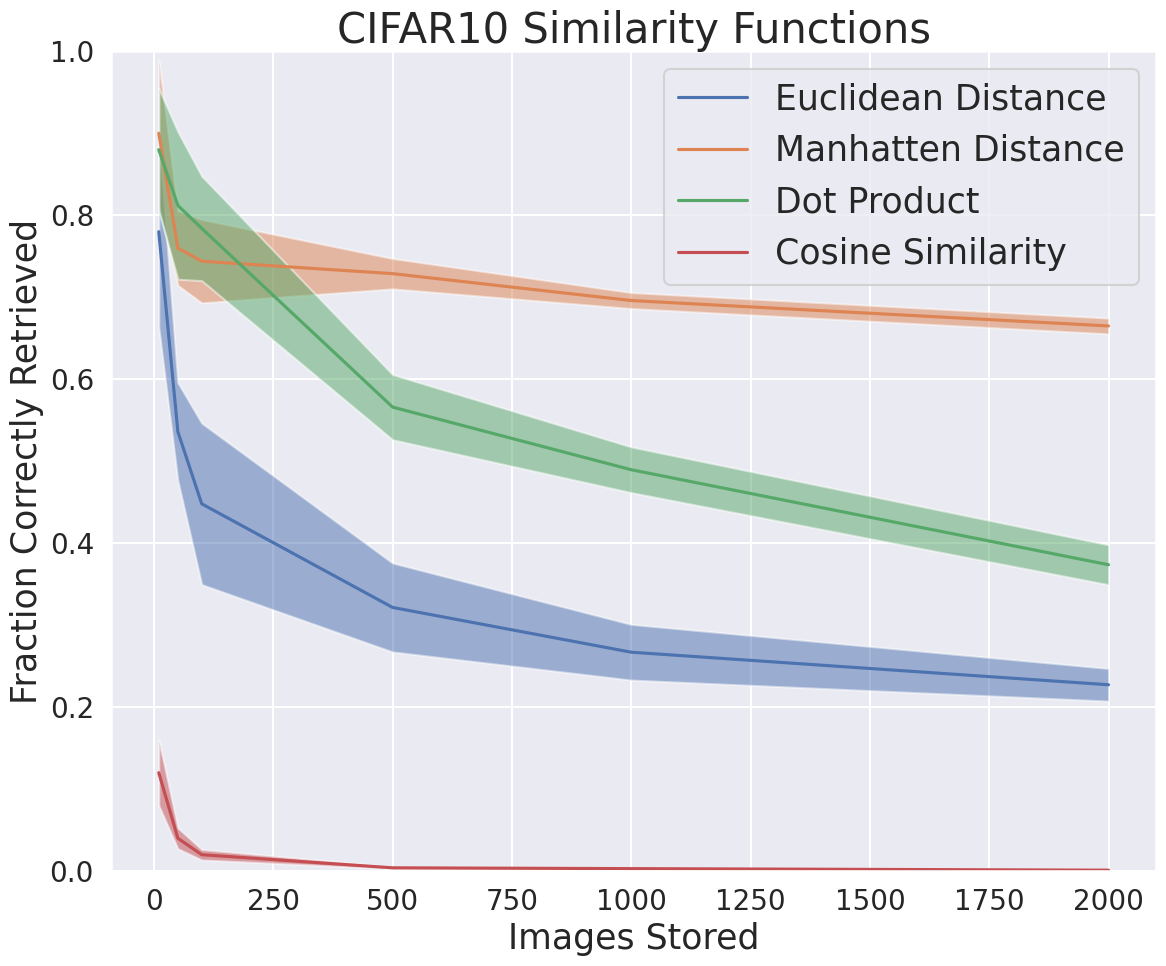

In [5]:
run_similarity_function_experiments(imgs, dataset_str, normalize_error_threshold = NORMALIZE_ERROR_THRESHOLD)


SIGMA:  0.05
Euclidean Distance
Manhatten Distance
Dot Product
Cosine Similarity
SIGMA:  0.1
Euclidean Distance
Manhatten Distance
Dot Product
Cosine Similarity
SIGMA:  0.2
Euclidean Distance
Manhatten Distance
Dot Product
Cosine Similarity
SIGMA:  0.3
Euclidean Distance
Manhatten Distance
Dot Product
Cosine Similarity
SIGMA:  0.5
Euclidean Distance
Manhatten Distance
Dot Product
Cosine Similarity
SIGMA:  0.8
Euclidean Distance
Manhatten Distance
Dot Product
Cosine Similarity
SIGMA:  1
Euclidean Distance
Manhatten Distance
Dot Product
Cosine Similarity
SIGMA:  1.5
Euclidean Distance
Manhatten Distance
Dot Product
Cosine Similarity
SIGMA:  0.05
Euclidean Distance
Manhatten Distance
Dot Product
Cosine Similarity
SIGMA:  0.1
Euclidean Distance
Manhatten Distance
Dot Product
Cosine Similarity
SIGMA:  0.2
Euclidean Distance
Manhatten Distance
Dot Product
Cosine Similarity
SIGMA:  0.3
Euclidean Distance
Manhatten Distance
Dot Product
Cosine Similarity
SIGMA:  0.5
Euclidean Distance
Manhatten

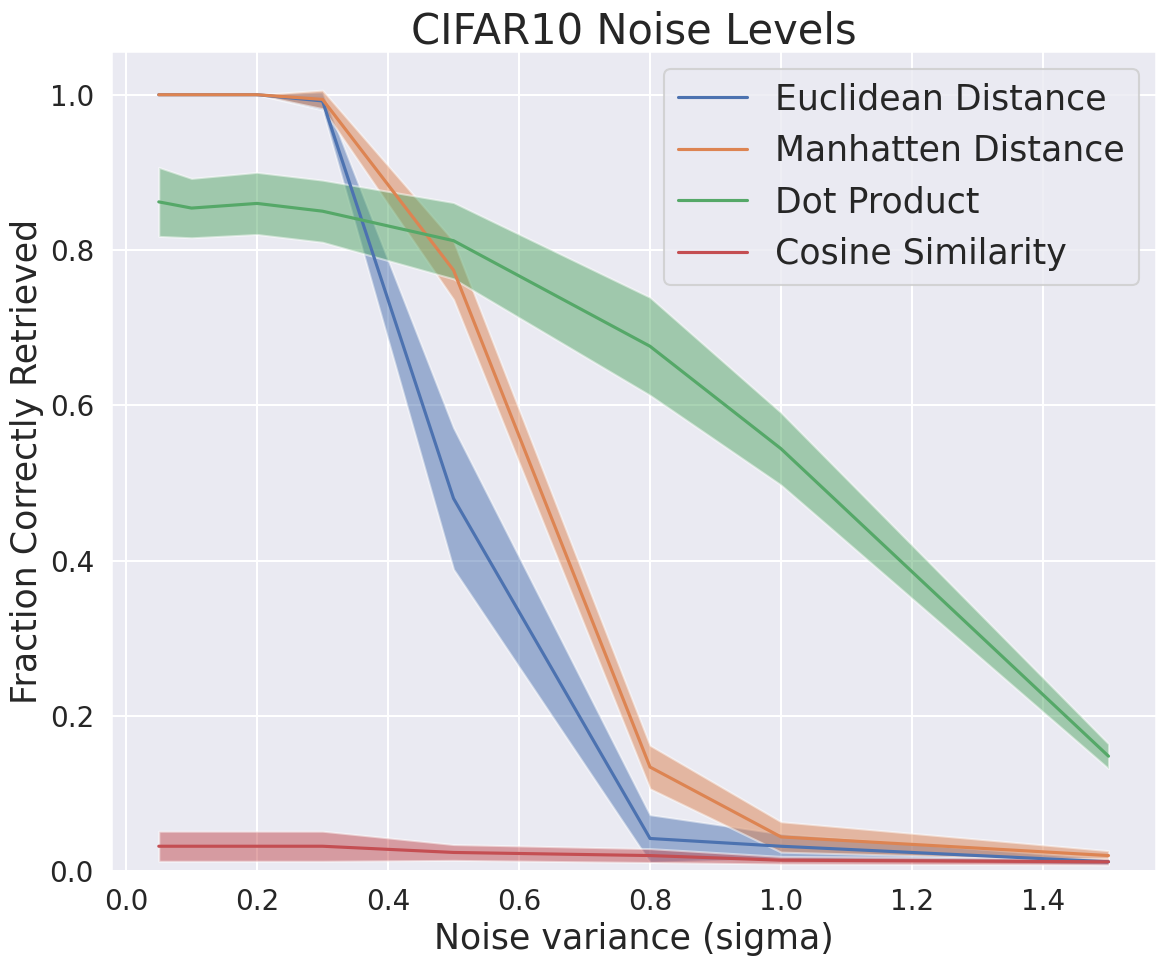

(5, 8, 4)


In [6]:
run_noise_levels_experiments(imgs, dataset_str)

### Load mnist data

In [7]:
dataset_str = "mnist_"

NORMALIZE_ERROR_THRESHOLD = True

PLOT_RESULTS = True
LOAD_DATA = False
imgs = []
if not LOAD_DATA:
    if dataset_str == "mnist_":
        trainset_mnist, testset_mnist = load_mnist(60000)
        imgs = trainset_mnist[0][0]
    if dataset_str == "" or dataset_str == "cifar_10_" or dataset_str == "cifar":
        trainset_cifar, testset_cifar = get_cifar10(10000)
        imgs = trainset_cifar[0][0]




Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 41580950.44it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1199268.31it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 10976281.27it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7635482.47it/s]


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

trainset:  Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
trainloader:  <torch.utils.data.dataloader.DataLoader object at 0x7de996cee200>


ERROR THRESHHOLD
torch.Size([1, 28, 28])
EUCLIDEAN DISTANCE
10
50
100
500
1000
2000
MANHATTEN DISTANCE
10
50
100
500
1000
2000
DOT PRODUCT
10
50
100
500
1000
2000
COSINE SIMILARITY
10
50
100
500
1000
2000
ERROR THRESHHOLD
torch.Size([1, 28, 28])
EUCLIDEAN DISTANCE
10
50
100
500
1000
2000
MANHATTEN DISTANCE
10
50
100
500
1000
2000
DOT PRODUCT
10
50
100
500
1000
2000
COSINE SIMILARITY
10
50
100
500
1000
2000
ERROR THRESHHOLD
torch.Size([1, 28, 28])
EUCLIDEAN DISTANCE
10
50
100
500
1000
2000
MANHATTEN DISTANCE
10
50
100
500
1000
2000
DOT PRODUCT
10
50
100
500
1000
2000
COSINE SIMILARITY
10
50
100
500
1000
2000
ERROR THRESHHOLD
torch.Size([1, 28, 28])
EUCLIDEAN DISTANCE
10
50
100
500
1000
2000
MANHATTEN DISTANCE
10
50
100
500
1000
2000
DOT PRODUCT
10
50
100
500
1000
2000
COSINE SIMILARITY
10
50
100
500
1000
2000
ERROR THRESHHOLD
torch.Size([1, 28, 28])
EUCLIDEAN DISTANCE
10
50
100
500
1000
2000
MANHATTEN DISTANCE
10
50
100
500
1000
2000
DOT PRODUCT
10
50
100
500
1000
2000
COSINE SIMILARITY

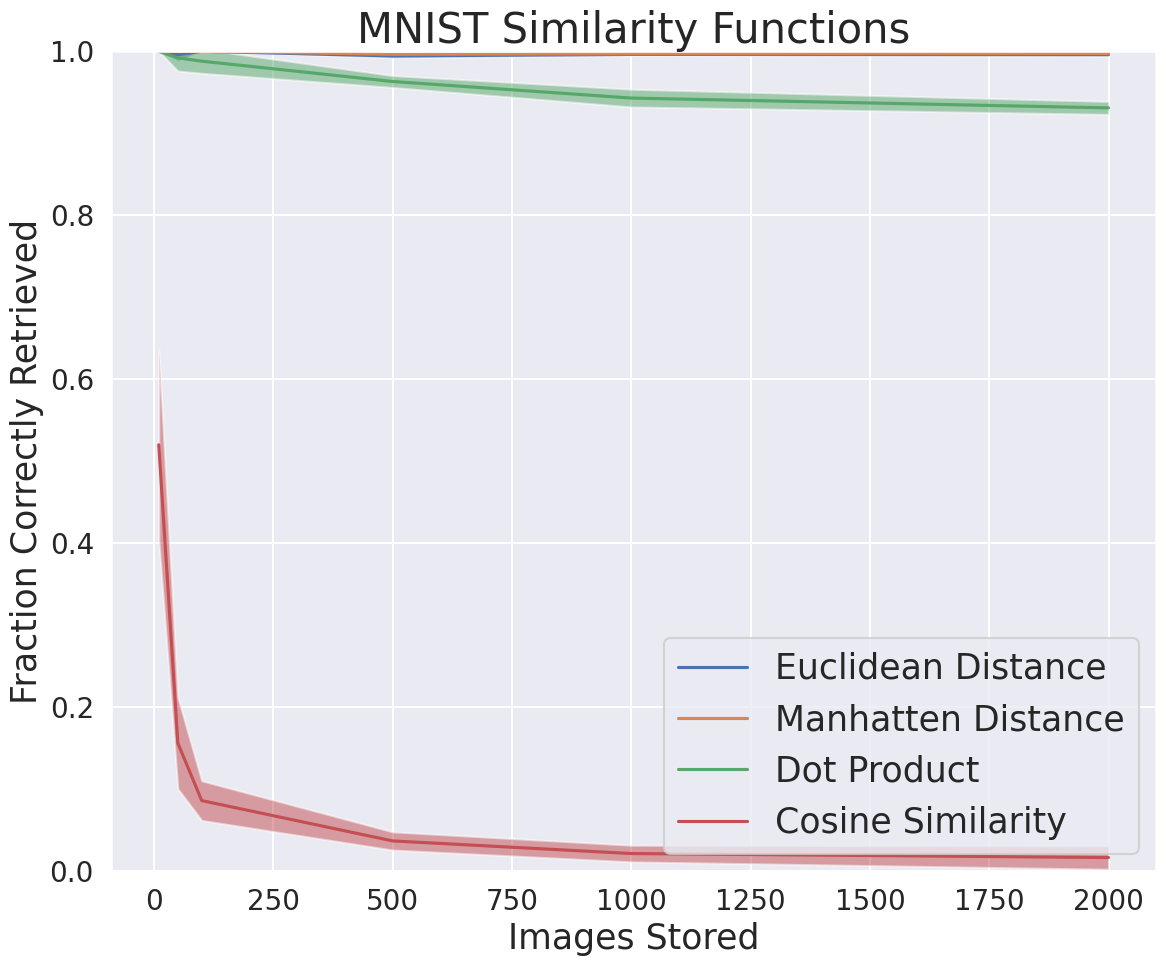

In [8]:
run_similarity_function_experiments(imgs, dataset_str, normalize_error_threshold = NORMALIZE_ERROR_THRESHOLD)


SIGMA:  0.05
Euclidean Distance
Manhatten Distance
Dot Product
Cosine Similarity
SIGMA:  0.1
Euclidean Distance
Manhatten Distance
Dot Product
Cosine Similarity
SIGMA:  0.2
Euclidean Distance
Manhatten Distance
Dot Product
Cosine Similarity
SIGMA:  0.3
Euclidean Distance
Manhatten Distance
Dot Product
Cosine Similarity
SIGMA:  0.5
Euclidean Distance
Manhatten Distance
Dot Product
Cosine Similarity
SIGMA:  0.8
Euclidean Distance
Manhatten Distance
Dot Product
Cosine Similarity
SIGMA:  1
Euclidean Distance
Manhatten Distance
Dot Product
Cosine Similarity
SIGMA:  1.5
Euclidean Distance
Manhatten Distance
Dot Product
Cosine Similarity
SIGMA:  0.05
Euclidean Distance
Manhatten Distance
Dot Product
Cosine Similarity
SIGMA:  0.1
Euclidean Distance
Manhatten Distance
Dot Product
Cosine Similarity
SIGMA:  0.2
Euclidean Distance
Manhatten Distance
Dot Product
Cosine Similarity
SIGMA:  0.3
Euclidean Distance
Manhatten Distance
Dot Product
Cosine Similarity
SIGMA:  0.5
Euclidean Distance
Manhatten

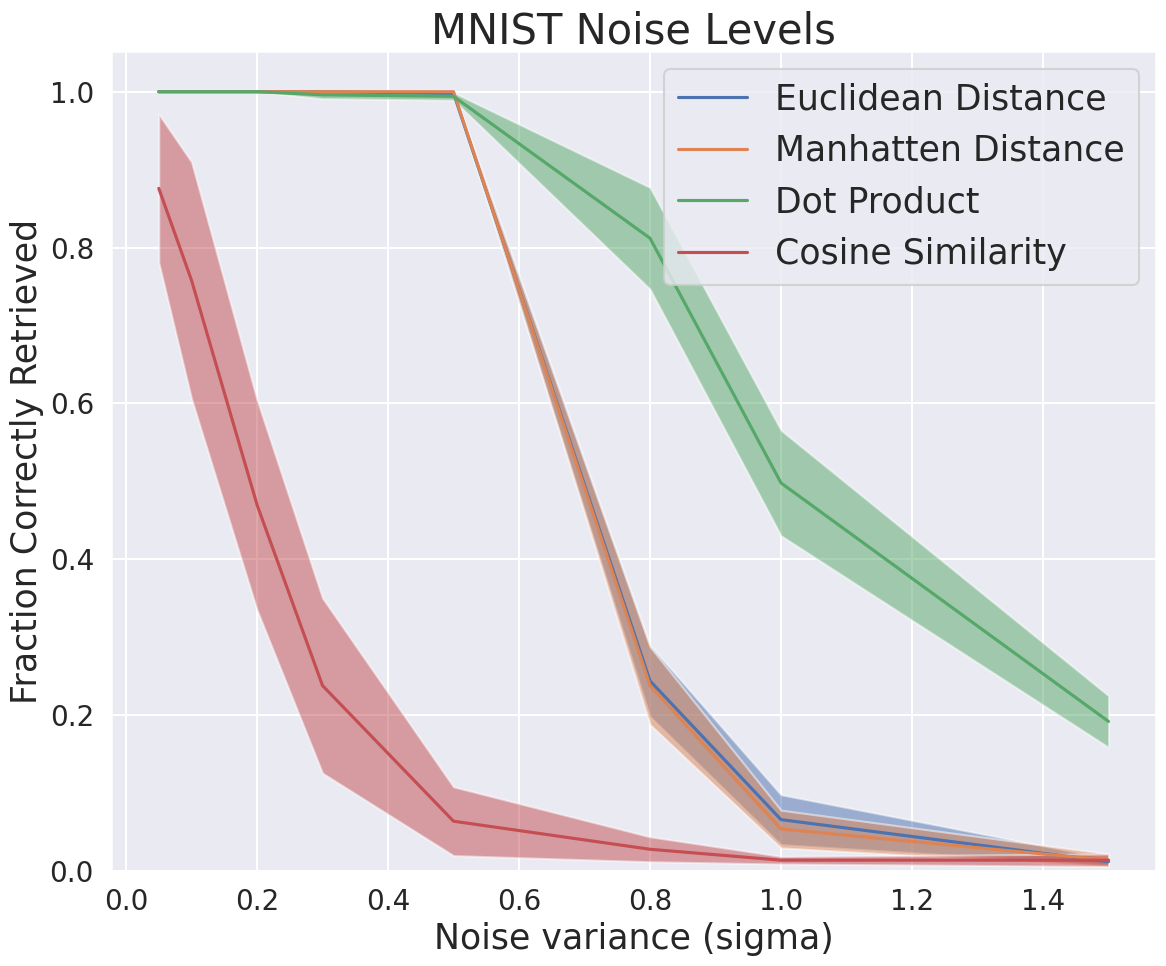

(5, 8, 4)


In [9]:
run_noise_levels_experiments(imgs, dataset_str)